<a href="https://colab.research.google.com/github/Seungki-Jeong/Deep-Learning-with-Colab/blob/master/Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!mkdir model

In [5]:
!ls -l

total 8
drwxr-xr-x 2 root root 4096 Jul  7 07:03 model
drwxr-xr-x 1 root root 4096 Jun 26 16:26 sample_data


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

(X_train, y_train0), (X_test, y_test0) = cifar10.load_data()
print(X_train.shape, X_train.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test.shape, X_test.dtype)
print(y_test0.shape, y_test0.dtype)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) uint8
(50000, 1) uint8
(10000, 32, 32, 3) uint8
(10000, 1) uint8


In [7]:
import numpy as np

In [8]:
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_train.dtype)

(50000, 32, 32, 3) float32


In [10]:
Y_train = tf.keras.utils.to_categorical(y_train0, 10)
Y_test = tf.keras.utils.to_categorical(y_test0, 10)
Y_train[:4]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Activation, BatchNormalization
from keras.regularizers import l2
import numpy as np

In [12]:
np.random.seed(0)
weight_decay = 1e-6

In [13]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

In [14]:
from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=0.001, decay=weight_decay), 
              metrics=['accuracy'])

In [15]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 40:
        lrate = 0.0003
    return lrate

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
modelpath = "model/dogs_vs_cats-cnn-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [20]:
from keras.callbacks import LearningRateScheduler
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
                    steps_per_epoch=X_train.shape[0] // 64, epochs=300,
                    verbose=1, validation_data=(X_test, Y_test),
                    callbacks=[LearningRateScheduler(lr_schedule), checkpointer, early_stopping_callback])

Epoch 1/300
781/781 [==============================] - 56s 71ms/step - loss: 1.9101 - accuracy: 0.4016 - val_loss: 1.2819 - val_accuracy: 0.5709

Epoch 00001: val_loss improved from inf to 1.28194, saving model to model/dogs_vs_cats-cnn-01-1.2819.hdf5
Epoch 2/300
781/781 [==============================] - 49s 62ms/step - loss: 1.2381 - accuracy: 0.5730 - val_loss: 0.9595 - val_accuracy: 0.6781

Epoch 00002: val_loss improved from 1.28194 to 0.95948, saving model to model/dogs_vs_cats-cnn-02-0.9595.hdf5
Epoch 3/300
781/781 [==============================] - 49s 62ms/step - loss: 1.0254 - accuracy: 0.6442 - val_loss: 1.0363 - val_accuracy: 0.6736

Epoch 00003: val_loss did not improve from 0.95948
Epoch 4/300
781/781 [==============================] - 48s 62ms/step - loss: 0.9057 - accuracy: 0.6836 - val_loss: 1.1022 - val_accuracy: 0.6683

Epoch 00004: val_loss did not improve from 0.95948
Epoch 5/300
781/781 [==============================] - 47s 61ms/step - loss: 0.8296 - accuracy: 0.

In [28]:
from tensorflow.keras.models import load_model
model_1 = load_model('model/dogs_vs_cats-cnn-58-0.3572.hdf5')

In [29]:
scores = model_1.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 8ms/step - loss: 0.3572 - accuracy: 0.8828
Test loss: 0.35722947120666504
Test accuracy: 0.8827999830245972


In [22]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

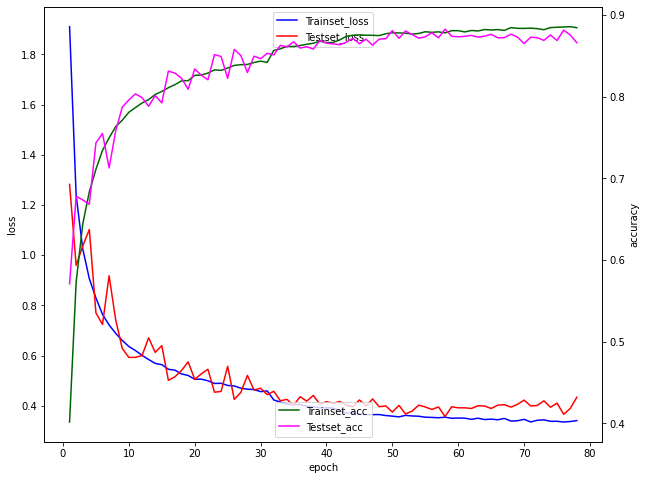

In [25]:
# 그래프로 표현
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper center')
ax1.legend(loc='lower center')
plt.show()